### Choosing the Right Metric


<center>
    <img src = 'images/uci_biz.png'/>
</center>


This module introduced both the K Nearest Neighbors model as well as a variety of different metrics for classification.  It is important to select and understand the appropriate metric for your task.  This exercise is meant to get practice considering the difference between these new classification metrics and accompanying evaluation tools. Specifically, explore datasets related to business from the UCI Machine Learning Repository [here](https://archive-beta.ics.uci.edu/ml/datasets?f%5Barea%5D%5B0%5D=business&p%5Boffset%5D=0&p%5Blimit%5D=10&p%5BorderBy%5D=NumHits&p%5Border%5D=desc&p%5BStatus%5D=APPROVED).  

Select a dataset of interest and clearly state the classification task.  Specifically, describe a business problem that could be solved using the dataset and a KNN classification model.  Further, identify what you believe to be the appropriate metric and justify your choice.  Build a basic model with the `KNearestNeighbor` and grid search to optimize towards your chosen metric.  Share your results with your peers.

Business Problem: Predicting the priority level of IT incidents to optimize response times and resource allocation. This is crucial for IT service management, ensuring that high-priority incidents are addressed promptly.

We'll use the KNN classification model to classify incidents into different priority levels based on their attributes. The appropriate metric for this task could be accuracy, as it's essential to correctly classify incidents to ensure appropriate resource allocation.

Datasource: https://archive.ics.uci.edu/dataset/498/incident+management+process+enriched+event+log

Dataset Information
Additional Information

This is an event log of an incident management process extracted from data gathered from the audit system of an instance of the ServiceNowTM platform used by an IT company. The event log is enriched with data loaded from a relational database underlying a corresponding process-aware information system. Information was anonymized for privacy.

Number of instances: 141,712 events (24,918 incidents)
Number of attributes: 36 attributes (1 case identifier, 1 state identifier, 32 descriptive attributes, 2 dependent variables)

The attributed â€˜closed_atâ€™ is used to determine the dependent variable for the time completion prediction task. The attribute â€˜resolved_atâ€™ is highly correlated with â€˜closed_atâ€™. In this event log, some rows may have the same values (they are equal) since not all attributes involved in the real-world process are present in the log.

Attributes used to record textual information are not placed in this log.

The missing values should be considered â€˜unknown informationâ€™.

We focus on top 5 features/columns from the dataset, priority is the target

1) Urgency (urgency): How quickly a resolution is required for the incident.
2) Impact (impact): The effect of the incident on business processes.
3) Incident State (incident_state): The current status of the incident.
4) Category/Subcategory (category, subcategory): The classification of the incident.
5) Service Level Agreement Compliance (made_sla): Whether the handling of the incident was within the agreed service levels.

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from itertools import cycle
from joblib import Parallel, delayed

In [28]:
# Load the dataset
df = pd.read_csv('data/incident_event_log.csv')

In [29]:
# Assume 'priority' is the target variable
target_variable = 'priority'

In [30]:
# Select relevant columns
selected_columns = [
    'urgency', 'impact', 'incident_state', 'category', 
    'subcategory', 'made_sla'
]

# Reduce the dataset to the selected columns
df_selected = df[selected_columns + [target_variable]].copy()
df_selected.replace('?', pd.NA, inplace=True)

In [31]:
# Handle missing values
# Here we replace missing values with the mode (most frequent value) as an example
for column in selected_columns:
    df_selected[column].fillna(df_selected[column].mode()[0], inplace=True)

df_selected.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   urgency         141712 non-null  object
 1   impact          141712 non-null  object
 2   incident_state  141712 non-null  object
 3   category        141712 non-null  object
 4   subcategory     141712 non-null  object
 5   made_sla        141712 non-null  bool  
 6   priority        141712 non-null  object
dtypes: bool(1), object(6)
memory usage: 6.6+ MB


In [32]:
# Encode categorical variables
# For 'urgency', 'impact', and 'incident_state', let's assume they have a manageable number of unique values
# and we will use one-hot encoding for them.
sampled_df = pd.get_dummies(df_selected, columns=['urgency', 'impact', 'incident_state'])
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   category                           141712 non-null  int64
 1   subcategory                        141712 non-null  int64
 2   made_sla                           141712 non-null  int64
 3   priority                           141712 non-null  int64
 4   urgency_1 - High                   141712 non-null  bool 
 5   urgency_2 - Medium                 141712 non-null  bool 
 6   urgency_3 - Low                    141712 non-null  bool 
 7   impact_1 - High                    141712 non-null  bool 
 8   impact_2 - Medium                  141712 non-null  bool 
 9   impact_3 - Low                     141712 non-null  bool 
 10  incident_state_-100                141712 non-null  bool 
 11  incident_state_Active              141712 non-null  bool 
 12  in

In [33]:
# For 'category' and 'subcategory', which might have many unique values,
# let's use label encoding to avoid high dimensionality.
le_category = LabelEncoder()
df_encoded['category'] = le_category.fit_transform(df_selected['category'])

le_subcategory = LabelEncoder()
df_encoded['subcategory'] = le_subcategory.fit_transform(df_selected['subcategory'])

# Convert boolean 'made_sla' to integer
df_encoded['made_sla'] = sampled_df['made_sla'].astype(int)

df_encoded['priority'] = le_category.fit_transform(df_encoded['priority'])

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   category                           141712 non-null  int64
 1   subcategory                        141712 non-null  int64
 2   made_sla                           141712 non-null  int64
 3   priority                           141712 non-null  int64
 4   urgency_1 - High                   141712 non-null  bool 
 5   urgency_2 - Medium                 141712 non-null  bool 
 6   urgency_3 - Low                    141712 non-null  bool 
 7   impact_1 - High                    141712 non-null  bool 
 8   impact_2 - Medium                  141712 non-null  bool 
 9   impact_3 - Low                     141712 non-null  bool 
 10  incident_state_-100                141712 non-null  bool 
 11  incident_state_Active              141712 non-null  bool 
 12  in

In [34]:
# Reduce the size by random sampling to 5% of its original size
sampled_df = df_encoded.sample(frac=0.05, random_state=42)
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7086 entries, 77220 to 5582
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   category                           7086 non-null   int64
 1   subcategory                        7086 non-null   int64
 2   made_sla                           7086 non-null   int64
 3   priority                           7086 non-null   int64
 4   urgency_1 - High                   7086 non-null   bool 
 5   urgency_2 - Medium                 7086 non-null   bool 
 6   urgency_3 - Low                    7086 non-null   bool 
 7   impact_1 - High                    7086 non-null   bool 
 8   impact_2 - Medium                  7086 non-null   bool 
 9   impact_3 - Low                     7086 non-null   bool 
 10  incident_state_-100                7086 non-null   bool 
 11  incident_state_Active              7086 non-null   bool 
 12  incident_state_Awaiti

In [35]:
# Preprocessing
# Assuming 'priority' is the target variable
X = sampled_df.drop(target_variable, axis=1)
y = sampled_df[target_variable]

In [36]:
# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

In [37]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [38]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# KNN Model
knn = KNeighborsClassifier(n_neighbors=5)  # Starting with 5 neighbors, can be tuned
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [40]:
y_pred = knn.predict(X_test_scaled)

In [41]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [42]:
# Ensure 'priority' is a single label per instance
# Check the format of 'priority' and convert if necessary
if y_test.dtype == 'object' or isinstance(y_test, pd.Series):
    le = LabelEncoder()
    y_test = le.fit_transform(y_test)
    y_pred = le.transform(y_pred)
elif len(y_test.shape) > 1 and y_test.shape[1] > 1:
    # Convert one-hot encoded labels to single labels
    y_test = y_test.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)


In [43]:
# Grid Search for Parameter Tuning
param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [44]:
# Best Parameters and Accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [45]:
# Predicting on the Test Set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [46]:
# Output
best_params, best_score, test_accuracy

({'n_neighbors': 3, 'weights': 'distance'},
 0.9699596774193548,
 0.9666039510818438)

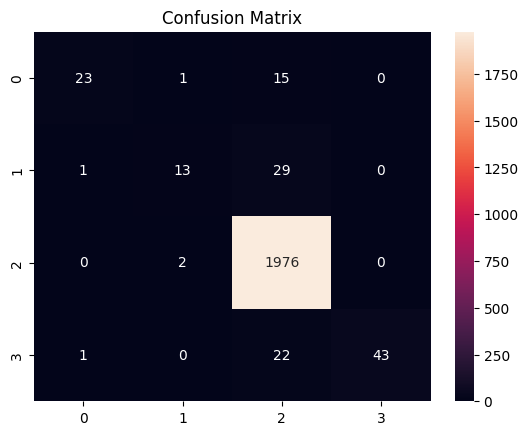

In [47]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.savefig('images/confusion_matrix.png')
plt.show()

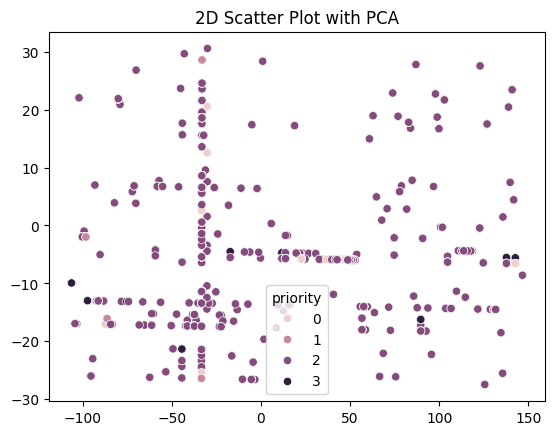

In [48]:
# PCA for 2D scatter plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y)
plt.title("2D Scatter Plot with PCA")
plt.savefig('images/scatterwithpca.png')
plt.show()


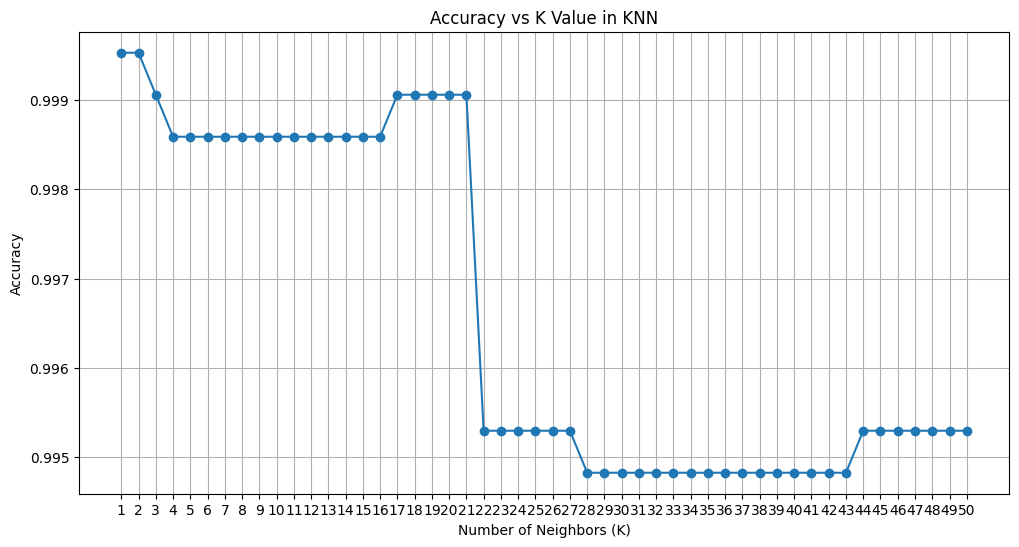

In [49]:
# Range of K to try
k_values = range(1, 51)
accuracies = []

for k in k_values:
    # Create and fit the model for each K
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_scaled)

    # Calculate and record accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting accuracy vs K values
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K Value in KNN')
plt.xticks(range(1, 51))
plt.grid(True)
plt.savefig('images/acc_vs_k_value.png')
plt.show()

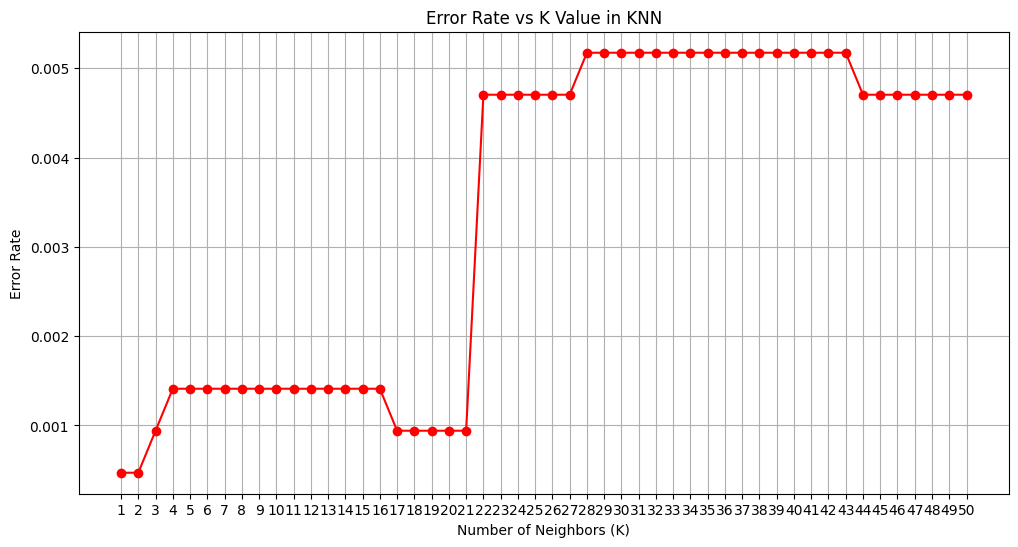

In [26]:
# Range of K to try
k_values = range(1, 51)
error_rates = []

for k in k_values:
    # Create and fit the model for each K
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test_scaled)

    # Calculate and record error rate (1 - accuracy)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

# Plotting error rate vs K values
plt.figure(figsize=(12, 6))
plt.plot(k_values, error_rates, marker='o', linestyle='-', color='red')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Error Rate')
plt.title('Error Rate vs K Value in KNN')
plt.xticks(range(1, 51))
plt.grid(True)
plt.savefig('images/errr_vs_k_value.png')
plt.show()

In [50]:
print(sampled_df.columns)

Index(['category', 'subcategory', 'made_sla', 'priority', 'urgency_1 - High',
       'urgency_2 - Medium', 'urgency_3 - Low', 'impact_1 - High',
       'impact_2 - Medium', 'impact_3 - Low', 'incident_state_-100',
       'incident_state_Active', 'incident_state_Awaiting Evidence',
       'incident_state_Awaiting Problem', 'incident_state_Awaiting User Info',
       'incident_state_Awaiting Vendor', 'incident_state_Closed',
       'incident_state_New', 'incident_state_Resolved'],
      dtype='object')


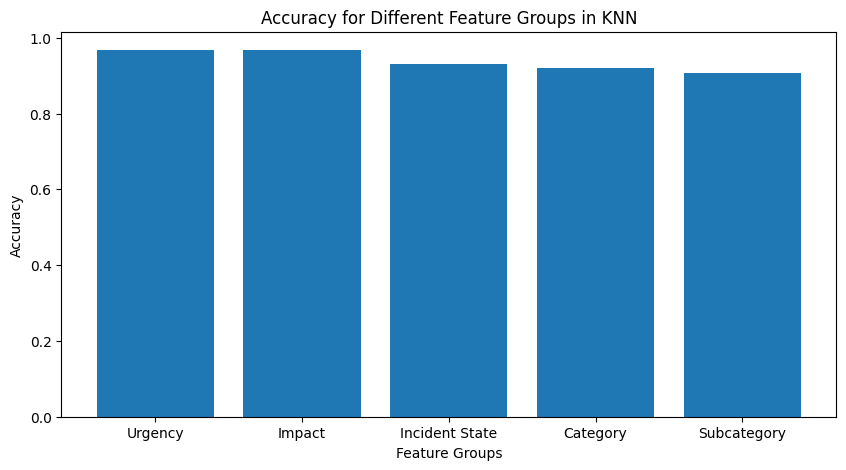

In [52]:
feature_groups = {
    'Urgency': [col for col in sampled_df.columns if col.startswith('urgency_')],
    'Impact': [col for col in sampled_df.columns if col.startswith('impact_')],
    'Incident State': [col for col in sampled_df.columns if col.startswith('incident_state_')]
}

# We also evaluate 'category' and 'subcategory' which have not been one-hot encoded
feature_groups['Category'] = ['category']
feature_groups['Subcategory'] = ['subcategory']

# The dictionary to store the accuracy of the model when trained on each group of features
group_accuracies = {}

# Iterate over each feature group to train a model and record its accuracy
for group_name, columns in feature_groups.items():
    # Select the current group of features and the target variable
    X = sampled_df[columns]
    y = sampled_df['priority']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    knn = KNeighborsClassifier(n_neighbors=3)  # Using the optimal K found previously
    knn.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = knn.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    group_accuracies[group_name] = accuracy

# Plotting the group accuracies
plt.figure(figsize=(10, 5))
plt.bar(group_accuracies.keys(), group_accuracies.values())
plt.xlabel('Feature Groups')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Feature Groups in KNN')
plt.savefig('images/acc_feature_groups_in_KNN.png')
plt.show()

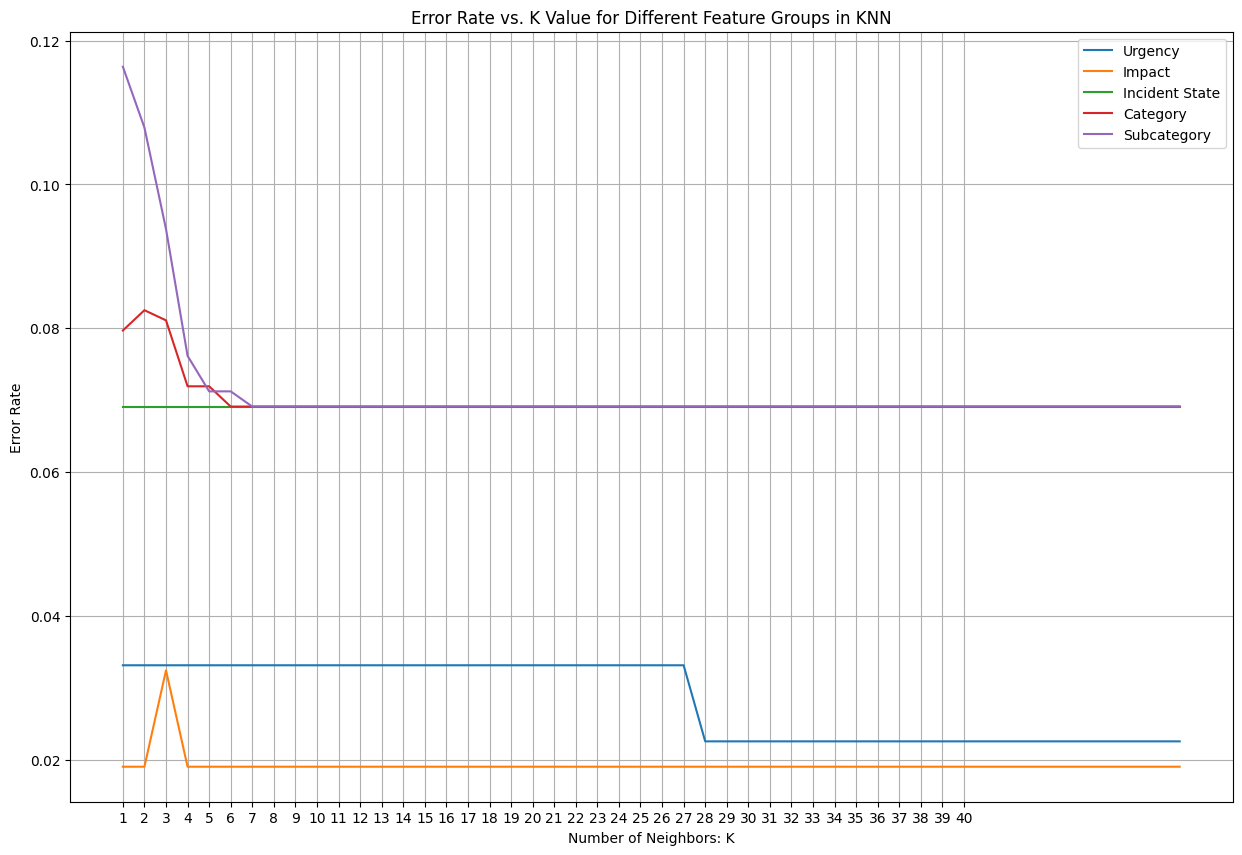

In [56]:
# Define a custom scorer function that calculates the error rate
def error_rate_scorer(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

# Custom scorer for GridSearchCV
error_scorer = make_scorer(error_rate_scorer, greater_is_better=False)

# Prepare the data for training and testing
y = sampled_df['priority'].values
X = sampled_df.drop('priority', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pre-scale features for each group and store scalers and data
pre_scaled_data = {}
for group_name, features in feature_groups.items():
    scaler = StandardScaler()
    pre_scaled_data[group_name] = {
        'scaler': scaler,
        'X_train_scaled': scaler.fit_transform(X_train[features]),
        'X_test_scaled': scaler.transform(X_test[features])
    }

# Function to train KNN model and calculate error rate for a given feature group and K value
def train_and_evaluate_knn(group_name, k, data_dict):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_dict['X_train_scaled'], y_train)
    y_pred = knn.predict(data_dict['X_test_scaled'])
    return 1 - accuracy_score(y_test, y_pred)

# Loop over each feature group and value of K, and perform training and evaluation in parallel
group_error_rates = {group: Parallel(n_jobs=-1)(delayed(train_and_evaluate_knn)(group, k, pre_scaled_data[group]) for k in k_values) for group in feature_groups}

# Now plot the error rate vs. K for each feature group
plt.figure(figsize=(15, 10))
for group_name, error_rates in group_error_rates.items():
    plt.plot(k_values, error_rates, label=f'{group_name}')

plt.xlabel('Number of Neighbors: K')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. K Value for Different Feature Groups in KNN')
plt.legend()
plt.xticks(np.arange(1, 41, 1))
plt.grid(True)
plt.savefig('images/errvskgroupsinKNN.png')
plt.show()